TODO give credit for this function

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-wytd5gwl
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-wytd5gwl
     |████████████████████████████████| 50 kB 4.0 MB/s 
     |████████████████████████████████| 74 kB 1.5 MB/s 
     |████████████████████████████████| 145 kB 12.5 MB/s 
     |████████████████████████████████| 130 kB 15.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 749 kB 46.8 MB/s 
     |████████████████████████████████| 843 kB 42.7 MB/s 
     |████████████████████████████████| 596 kB 27.8 MB/s 
     |████████████████████████████████| 112 kB 51.3 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5687376 sha256=e3731841c776f7889218af44b6405e7c97f860fc62658a734ea6a58d268da3e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-8y3ty6ie/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import glob
import os
import math

import torch
import cv2
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import Visualizer

from multiprocessing import Pool, get_context, Process, set_start_method

In [23]:
def generate_predictions(zipped):
    # unzips packed information for process to perform predictions
    
    S3_SAVE_DIR = zipped[0]
    OUTPUT_SAVE_DIR = zipped[1]
    dir_name = zipped[2]
    INFERENCE_BATCH_SIZE = zipped[3]
    filepaths = zipped[4]
    ID = zipped[5]
    
    with torch.cuda.device(ID):
        

        # navigates to correct directory (process is spawned in /notebooks)

        os.chdir(S3_SAVE_DIR + dir_name)

        # sets up model for process

        setup_logger()
        cfg = get_cfg()
        cfg.merge_from_file("../../..//detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

        # sets prediction score threshold - this is commented out and defaults to 0.05 in Detectron2
        # if you would like to adjust the threshold, uncomment and set to the desired value in [0, 1)
        # cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

        # sets number of object classes to 7
        # ("Illustration/Photograph", "Photograph", "Comics/Cartoon", "Editorial Cartoon", "Map", "Headline", "Ad")
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

        # build model
        model = build_model(cfg)

        # see:  https://github.com/facebookresearch/detectron2/issues/282 
        # (must load weights this way if using model)
        DetectionCheckpointer(model).load("../../model_weights/model_final.pth")
        model.train(False) 

        # construct batches
        batches = chunk(filepaths, math.ceil(len(filepaths)/INFERENCE_BATCH_SIZE))

        # iterate through images
        for batch in batches:

            # sets up inputs by loading in all files in batch
            inputs = []

            # stores image dimensions
            dimensions = []

            # iterate through files in batch
            for file in batch:

                # read in image
                image = cv2.imread(file)

                # store image dimensions
                height, width, _ = image.shape
                dimensions.append([width, height])

                # perform inference on batch
                image = np.transpose(image,(2,0,1))
                # see https://github.com/facebookresearch/detectron2/issues/282 for in-depth description of why 
                # image is loaded in this way
                image_tensor = torch.from_numpy(image)
                inputs.append({"image": image_tensor})

            # performs inference
            outputs = model(inputs)

            # saves predictions
            predictions = {}

            # iterate over images in batch and save predictions to JSON
            for i in range(0, len(batch)):

                # saves filepath in format of ChronAm file structure
                predictions["filepath"] = dir_name + "data/" + batch[i].split("data_")[1].replace(dir_name, '').replace('_', '/').replace('.jpg', '.jp2')

                # parses metadata from filepath
                date_str = predictions["filepath"].split('/')[-2]
                predictions["batch"] = dir_name[:-1]
                predictions["lccn"] = predictions["filepath"].split('/')[-4]
                predictions["pub_date"] = str(datetime.date(int(date_str[:4]), int(date_str[4:6]), int(date_str[6:8])))
                predictions["edition_seq_num"] = int(date_str[8:10])
                if "a" in predictions["filepath"].split('/')[-1][:-4] or "b" in predictions["filepath"].split('/')[-1][:-4]:
                    continue
                predictions["page_seq_num"] = int(predictions["filepath"].split('/')[-1][:-4])
                
                # saves predictions
                # we first normalize the bounding box coordinates
                boxes = outputs[i]["instances"].get_fields()["pred_boxes"].to("cpu").tensor.tolist()
                normalized_boxes = []
                width = dimensions[i][0]
                height = dimensions[i][1]

                for box in boxes:
                    normalized_box = (box[0]/float(width), box[1]/float(height), box[2]/float(width), box[3]/float(height))
                    normalized_boxes.append(normalized_box)

                # saves additional outputs of predictions
                predictions["boxes"] = normalized_boxes
                predictions["scores"] = outputs[i]["instances"].get_fields()["scores"].to("cpu").tolist()
                predictions["pred_classes"] = outputs[i]["instances"].get_fields()["pred_classes"].to("cpu").tolist()

                with open(OUTPUT_SAVE_DIR + dir_name + batch[i].replace('.jpg','.json'), "w") as fp:
                    json.dump(predictions, fp)

In [10]:
# function that splits a list into n chunks for multiprocessing
def chunk(file_list, n_chunks):
    
    # make chunks of files to be distributed across processes
    chunks = []
    chunk_size = math.ceil(float(len(file_list))/n_chunks)
    for i in range(0, n_chunks-1):
        chunks.append(file_list[i*chunk_size:(i+1)*chunk_size])
    chunks.append(file_list[(n_chunks-1)*chunk_size:])
    
    return chunks

In [8]:
!ls

gdrive	sample_data


In [7]:
# sets number of GPUs available
N_GPUS = torch.cuda.device_count()

# sets batch size for GPU inference; using 1 to prevent any memory overflow edge case in pipeline
INFERENCE_BATCH_SIZE = 1

# sets start method to spawn for GPU multiprocessing
ctx = get_context('forkserver')

os.chdir('gdrive/My Drive/newspaper-navigator/newspaper-navigator/')

# sets destination for saving downloaded S3 files
S3_SAVE_DIR = os.getcwd() + '/DFKV_data/'
# sets destination for output files, containing new metadata
OUTPUT_SAVE_DIR = os.getcwd() + '/DFKV_output/'


dir_name = 'test/'
if not os.path.isdir(S3_SAVE_DIR + dir_name):
    os.mkdir(S3_SAVE_DIR + dir_name)
if not os.path.isdir(OUTPUT_SAVE_DIR + dir_name):
    os.mkdir(OUTPUT_SAVE_DIR + dir_name)


In [36]:
# now we generate predictions on all of the downloaded files
os.chdir(S3_SAVE_DIR + dir_name)

print("predicting on pages...")
        
# FOR MULTIPROCESSING
chunked_image_filepaths = chunk(glob.glob("*.jpg"), N_GPUS)


# https://stackoverflow.com/questions/31386613/python-multiprocessing-what-does-process-join-do
processes = []
for i in range(0, N_GPUS):
     zipped = [S3_SAVE_DIR, OUTPUT_SAVE_DIR, dir_name, INFERENCE_BATCH_SIZE, chunked_image_filepaths[i], i]
     print(zipped)
     p = ctx.Process(target=generate_predictions, args=(zipped,)) 
     p.start()
     processes.append(p)
     
            
for process in processes:
     process.join()

predicting on pages...
['/content/gdrive/My Drive/newspaper-navigator/newspaper-navigator/DFKV_data/', '/content/gdrive/My Drive/newspaper-navigator/newspaper-navigator/DFKV_output/', 'test/', 1, ['test1.jpg', 'test4.jpg', 'test2.jpg', 'test5.jpg', 'test3.jpg'], 0]


In [8]:
# OK now we try without all the multiprocessing, as we don't need it for now because of the very few images we test this on

def generate_predictions_no_process(zipped):
    # unzips packed information for process to perform predictions
    
    S3_SAVE_DIR = zipped[0]
    OUTPUT_SAVE_DIR = zipped[1]
    dir_name = zipped[2]
    INFERENCE_BATCH_SIZE = zipped[3]
    filepaths = zipped[4]
    ID = zipped[5]

        

    # navigates to correct directory (process is spawned in /notebooks)

    os.chdir(S3_SAVE_DIR + dir_name)

    # sets up model for process

    setup_logger()
    cfg = get_cfg()
    cfg.merge_from_file("../../..//detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

        # sets prediction score threshold - this is commented out and defaults to 0.05 in Detectron2
        # if you would like to adjust the threshold, uncomment and set to the desired value in [0, 1)
        # cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

        # sets number of object classes to 7
        # ("Illustration/Photograph", "Photograph", "Comics/Cartoon", "Editorial Cartoon", "Map", "Headline", "Ad")
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

        # build model
    model = build_model(cfg)

        # see:  https://github.com/facebookresearch/detectron2/issues/282 
        # (must load weights this way if using model)
    DetectionCheckpointer(model).load("../../model_weights/model_final.pth")
    model.train(False) 

        # construct batches
    batches = chunk(filepaths, math.ceil(len(filepaths)/INFERENCE_BATCH_SIZE))

        # iterate through images
    for batch in batches:

            # sets up inputs by loading in all files in batch
        inputs = []

            # stores image dimensions
        dimensions = []

            # iterate through files in batch
        for file in batch:

                # read in image
            image = cv2.imread(file)

                # store image dimensions
            height, width, _ = image.shape
            dimensions.append([width, height])

                # perform inference on batch
            image = np.transpose(image,(2,0,1))
                # see https://github.com/facebookresearch/detectron2/issues/282 for in-depth description of why 
                # image is loaded in this way
            image_tensor = torch.from_numpy(image)
            inputs.append({"image": image_tensor})

            # performs inference
        outputs = model(inputs)

            # saves predictions
        predictions = {}

            # iterate over images in batch and save predictions to JSON
        for i in range(0, len(batch)):

                # saves predictions
                # we first normalize the bounding box coordinates
            boxes = outputs[i]["instances"].get_fields()["pred_boxes"].to("cpu").tensor.tolist()
            normalized_boxes = []
            width = dimensions[i][0]
            height = dimensions[i][1]

            for box in boxes:
                normalized_box = (box[0]/float(width), box[1]/float(height), box[2]/float(width), box[3]/float(height))
                normalized_boxes.append(normalized_box)

                # saves additional outputs of predictions
            predictions["boxes"] = normalized_boxes
            predictions["scores"] = outputs[i]["instances"].get_fields()["scores"].to("cpu").tolist()
            predictions["pred_classes"] = outputs[i]["instances"].get_fields()["pred_classes"].to("cpu").tolist()

            with open(OUTPUT_SAVE_DIR + dir_name + batch[i].replace('.jpg','.json'), "w") as fp:
                json.dump(predictions, fp)


In [11]:
# now we generate predictions on all of the downloaded files
os.chdir(S3_SAVE_DIR + dir_name)

print("predicting on pages...")
        
# FOR MULTIPROCESSING
chunked_image_filepaths = chunk(glob.glob("*.jpg"), N_GPUS)


# https://stackoverflow.com/questions/31386613/python-multiprocessing-what-does-process-join-do
processes = []
for i in range(0, N_GPUS):
     zipped = [S3_SAVE_DIR, OUTPUT_SAVE_DIR, dir_name, INFERENCE_BATCH_SIZE, chunked_image_filepaths[i], i]
     generate_predictions_no_process(zipped,) 

predicting on pages...


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


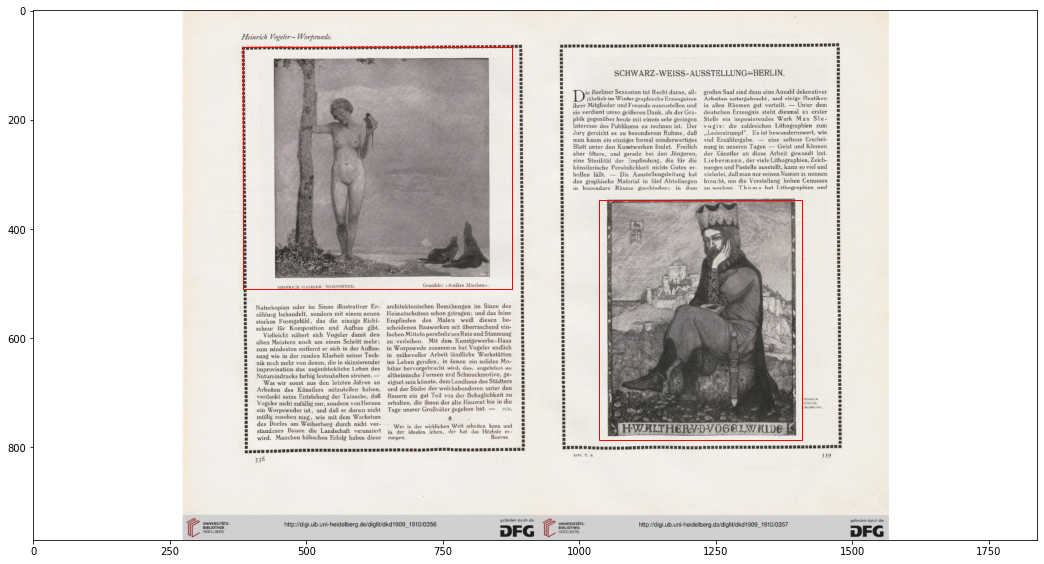

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle

IMG_TO_SHOW = 'test10'

os.chdir(S3_SAVE_DIR + dir_name)
plt.figure(figsize=(18, 18))
img = mpimg.imread(IMG_TO_SHOW + '.jpg')

im_h, im_w = img.shape[0], img.shape[1]

imgplot = plt.imshow(img)

os.chdir(OUTPUT_SAVE_DIR + dir_name)
f = open(IMG_TO_SHOW + '.json')
data = json.load(f)


# Get the current reference
ax = plt.gca()

for box, label, score in zip(data['boxes'], data['pred_classes'], data['scores']):
    if score > 0.66 and (label == 0 or label == 1 or label == 3):
        # Create a Rectangle patch
        x = im_w*box[0]
        y = im_h*box[1]
        w = im_w*box[2] - x
        h = im_h*box[3] - y
        rect = Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none') #(x,y), width, height

        # Add the patch to the Axes
        ax.add_patch(rect)

plt.show()